In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2


In [41]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
from ncdf_io import ncdf_io
from time_convert import time_convert
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams,rc
from Lambert_frame_tick import *

In [3]:
dir1='/Users/joedhsu/Research/Rsync/Data_p/GRACE05_JPLmscn/version2_102617/nonCRI/Ocnmass/'
file1='Omass.origrid.m.deg1.com004_175'

mfile1='COASTLINE_MASK.CRIv01'
dir2='/Users/joedhsu/Research/Rsync/Data/JPL_mascon/version2_102617/CRI/netcdf/'
mfile2='LAND_MASK.CRIv01'

/usr/local/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


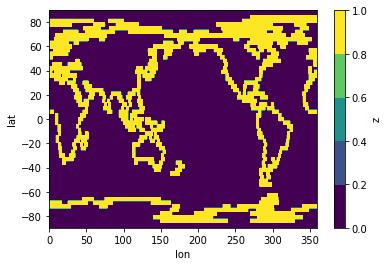

In [4]:
ncfile=ncdf_io(dir1+mfile1+'.nc',verbose=0)
ds_mask1=ncfile.read_ncdf2xarray()
ds_mask1['z'].plot.contourf()

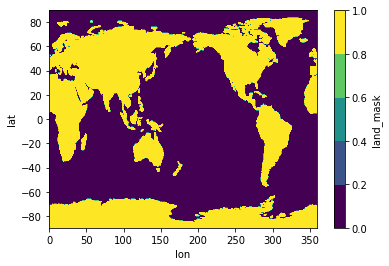

In [5]:
ncfile=ncdf_io(dir2+mfile2+'.nc',verbose=0)
ds_mask2=ncfile.read_ncdf2xarray(dimorder=['lat','lon'])
ds_mask2['land_mask'].plot.contourf()

/usr/local/lib/python2.7/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


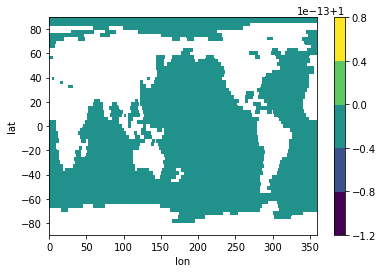

In [6]:
totmask=ds_mask1['z']+ds_mask2['land_mask']
totmask=totmask.where(totmask<1)+1
totmask.plot.contourf()
# totmask.where(totmask<1E-10,1)

/usr/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


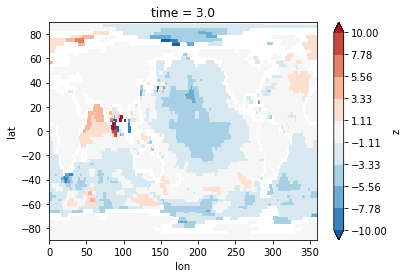

In [7]:
ncfile=ncdf_io(dir1+file1+'.nc',verbose=0)
ds=ncfile.read_ncdf2xarray()
ds['z'].isel(time=0).plot.contourf(levels=np.linspace(-10,10,10))

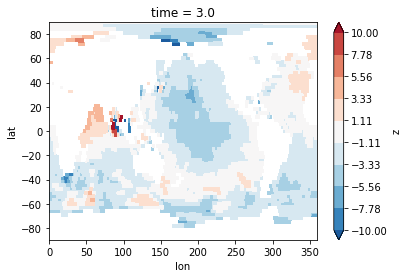

In [8]:
ds['z']=ds['z']*totmask
ds['z'].isel(time=0).plot.contourf(levels=np.linspace(-10,10,10))

In [9]:
# old time stamp (change from np.array to pd.index)
gmonth=np.array(ds['time'])+1   # start from 0 
tdict=time_convert(gmonth).gmonth2year_mon()
year=tdict['year']
month=tdict['month']
tstamp=pd.to_datetime([datetime.datetime(year[ii],month[ii],15) for ii in range(len(year))])

# assign new time stamp
ds['time']=xr.DataArray(tstamp,coords=[tstamp],dims=['time'])

In [10]:
ds.to_netcdf('./data/jpl_mascon_ocean.nc')
# ds_new=xr.open_dataset('./data/jpl_mascon_ocean.nc')    # testing the open_dataset function

In [11]:
ds_new.sel(time=datetime.datetime(2002,10,10),method='nearest')   # testing the time domain selection

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
    time     datetime64[ns] 2002-10-15
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
Data variables:
    z        (lat, lon) float64 ...

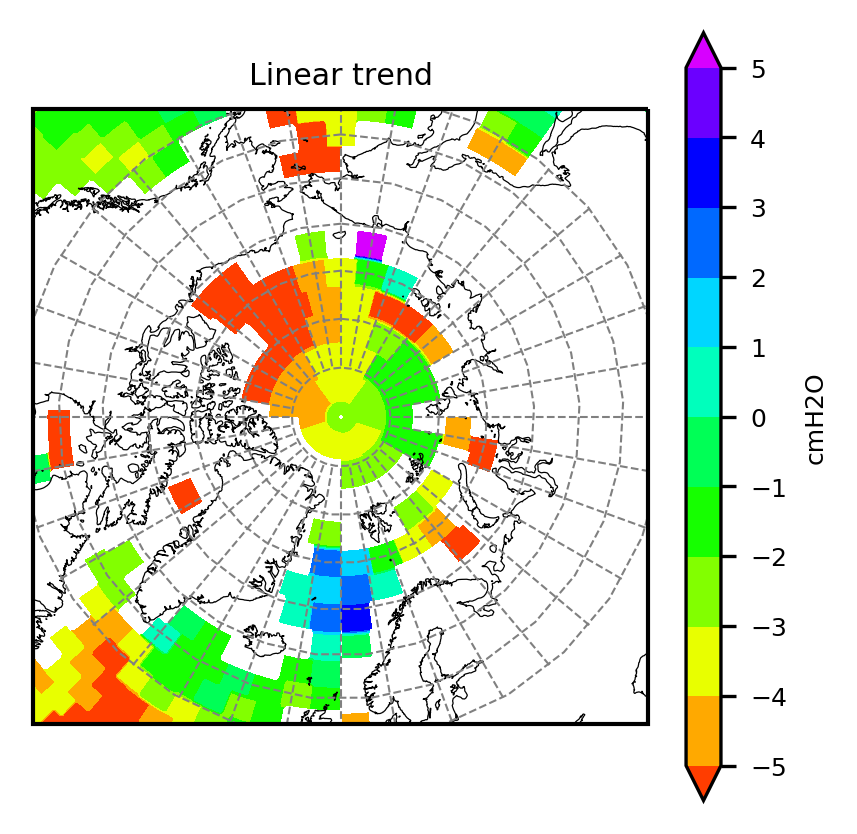

In [42]:
# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.Orthographic(-0, 90)    # rotating the center of the projection
#fig_proj = ccrs.LambertConformal(central_longitude=-50, central_latitude=45)
# fig_proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0)

# set the figure axes
hmm=65.    # mm
vmm=65.    # mm
fontsize=6
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams.update({'font.size': fontsize})
rc('font', family='sans-serif')
rc('font', serif='Helvetica')
mm2inch=0.0393701
hmm=hmm*mm2inch
vmm=vmm*mm2inch
fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
ax1=fig.add_axes([0,0,1,1],projection=fig_proj)

# plot the data in each axes
plot1=ds['z'].sel(time=datetime.datetime(2002,10,10),method='nearest').plot.contourf(ax=ax1, transform=data_proj
        , levels=np.linspace(-5,5,11), extend='both',cmap='gist_rainbow'
        , cbar_kwargs={'ticks': np.linspace(-5,5,11),'label':'cmH2O'})
ax1.set_title('Linear trend')
ax1.set_extent([-180,180,57,90], crs=data_proj)
ax1.coastlines(resolution='50m',linewidth=0.3)

####################  Grid on  ######################
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xtick=np.linspace(0,360,37)-180.  # need to be -180~180
ytick=np.linspace(55,85,7)

# Label the end-points of the gridlines using the custom tick makers:
ax1.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax1, xtick)
# lambert_yticks(ax1, ytick)


# # export the figure
# plt.savefig('./figures/regress_'+outfile[i]+'.pdf', dpi=300, facecolor='w', edgecolor='w',
#         orientation='landscape', papertype=None, format=None,
#         transparent=False, bbox_inches="tight", pad_inches=None,
#         frameon=None)

